# Swing Option Pricing Analysis: D4PG vs LSM Benchmark
## Quantitative Assessment of RL-Based Energy Derivatives Pricing

In [1]:
# Experiment Configuration
EXPERIMENT = 'MonthlySwing1'

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, json
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8'); sns.set_palette('husl')
%matplotlib inline

In [2]:
# Data Loading & Parameter Extraction
base_path = f'../logs/{EXPERIMENT}/'
with open(f'{base_path}{EXPERIMENT}_parameters.json') as f: params = json.load(f)
train_df = pd.read_csv(f'{base_path}{EXPERIMENT}_training.csv')
eval_df = pd.read_csv(f'{base_path}{EXPERIMENT}_evaluation.csv')
raw_df = pd.read_csv(f'{base_path}{EXPERIMENT}_raw_episodes.csv')

# Contract Parameters
S0, K, T, r = params['S0'], params['strike'], params['maturity'], params['risk_free_rate']
q_min, q_max, Q_max = params['q_min'], params['q_max'], params['Q_max']
n_rights = params['n_rights']
alpha, sigma, beta, lam = params['alpha'], params['sigma'], params['beta'], params['lam']

print(f"Contract: {n_rights} exercise rights over {T:.2f}Y | Strike: ${K} | Initial Spot: ${S0}")
print(f"Exercise Constraints: q∈[{q_min}, {q_max}], Q≤{Q_max} | HHK: α={alpha}, σ={sigma}, β={beta}, λ={lam}")

Contract: 22 exercise rights over 0.08Y | Strike: $100.0 | Initial Spot: $100.0
Exercise Constraints: q∈[0.0, 2.0], Q≤20.0 | HHK: α=12.0, σ=1.2, β=150.0, λ=6.0


## Option Pricing Convergence Analysis

In [3]:
# LSM Benchmark vs D4PG Convergence
lsm_price = eval_df[eval_df['eval_run'] == 'LSM_Benchmark']['option_price'].iloc[0]
lsm_std = eval_df[eval_df['eval_run'] == 'LSM_Benchmark']['price_std'].iloc[0]
d4pg_prices = eval_df[eval_df['eval_run'] != 'LSM_Benchmark']['option_price']
episodes = eval_df[eval_df['eval_run'] != 'LSM_Benchmark']['training_episode']

# Pricing Error Analysis
pricing_error = (d4pg_prices - lsm_price) / lsm_price * 100
final_error = pricing_error.iloc[-1]
convergence_episode = episodes[abs(pricing_error) < 5].iloc[0] if len(episodes[abs(pricing_error) < 5]) > 0 else np.nan

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(episodes, d4pg_prices, 'b-', alpha=0.8, label='D4PG Price')
ax1.axhline(lsm_price, color='r', linestyle='--', label=f'LSM Benchmark: ${lsm_price:.2f}±{lsm_std:.2f}')
ax1.fill_between(episodes, lsm_price-1.96*lsm_std, lsm_price+1.96*lsm_std, alpha=0.2, color='red')
ax1.set_xlabel('Training Episodes'); ax1.set_ylabel('Option Price ($)'); ax1.legend(); ax1.grid(True)
ax1.set_title('Price Convergence: D4PG vs LSM')

ax2.plot(episodes, pricing_error, 'g-', alpha=0.8)
ax2.axhline(0, color='k', linestyle='-', alpha=0.3); ax2.axhline(5, color='r', linestyle=':', alpha=0.5)
ax2.axhline(-5, color='r', linestyle=':', alpha=0.5)
ax2.set_xlabel('Training Episodes'); ax2.set_ylabel('Pricing Error (%)'); ax2.grid(True)
ax2.set_title(f'Pricing Error: Final={final_error:.2f}%')
plt.tight_layout(); plt.show()

print(f"LSM Benchmark: ${lsm_price:.2f} ± ${lsm_std:.2f} (95% CI: ±${1.96*lsm_std:.2f})")
print(f"D4PG Final: ${d4pg_prices.iloc[-1]:.2f} | Error: {final_error:.2f}%")
if not np.isnan(convergence_episode): print(f"Convergence (<5% error): Episode {convergence_episode:,.0f}")

IndexError: single positional indexer is out-of-bounds

## Exercise Strategy Analysis

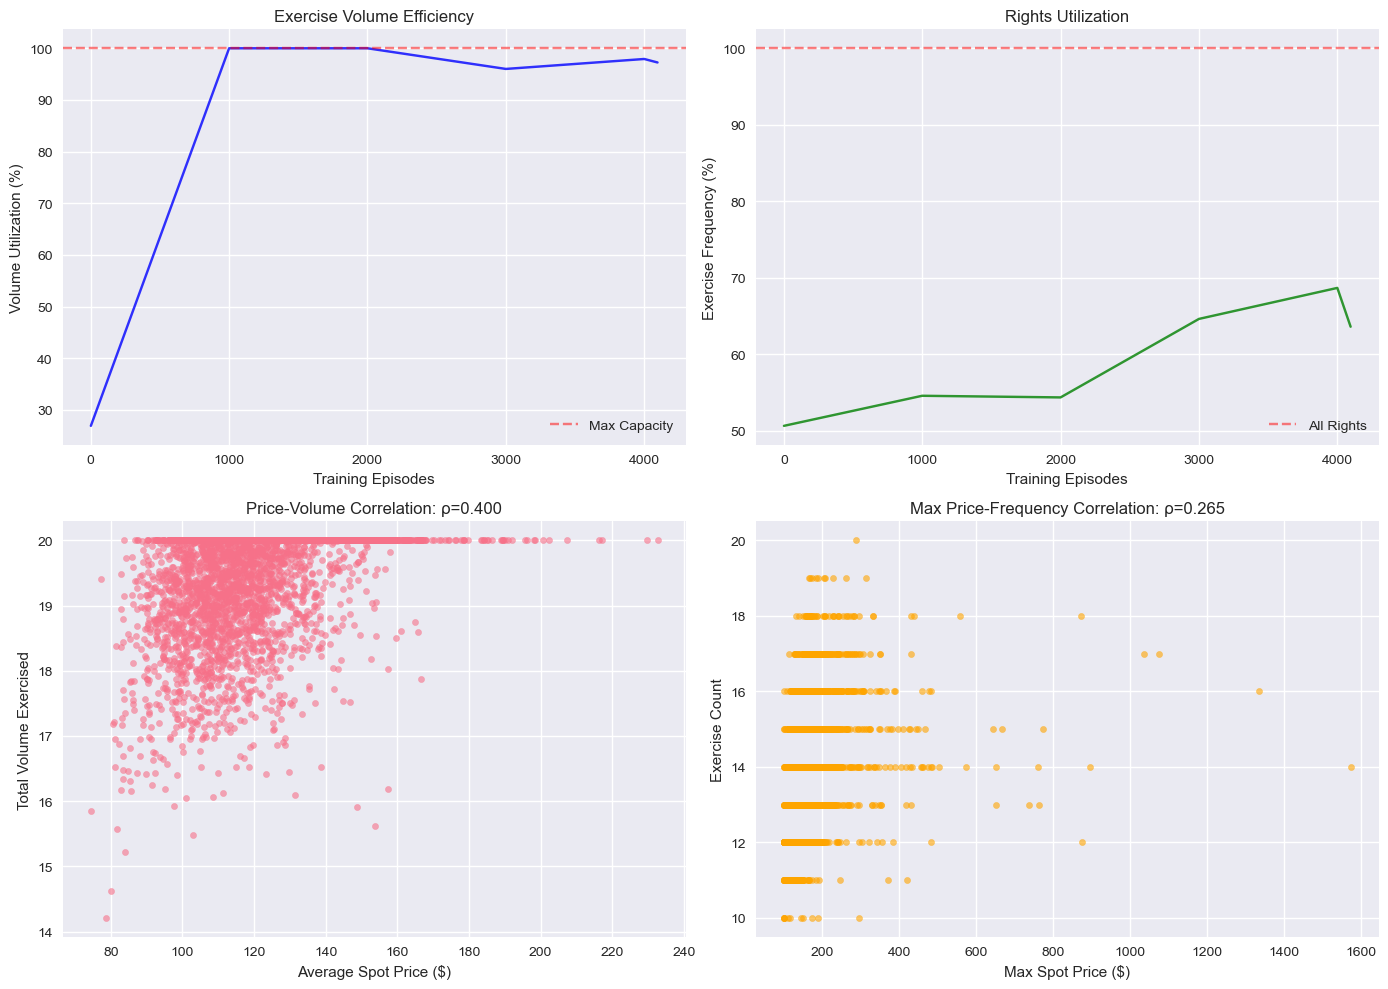

Final Strategy Metrics:
Volume Utilization: 97.3% | Rights Usage: 63.6%
Price-Volume Correlation: 0.400 | Max Price-Frequency: 0.265


In [ ]:
# Exercise Strategy Evolution
eval_clean = eval_df[eval_df['eval_run'] != 'LSM_Benchmark']
exercise_efficiency = eval_clean['avg_total_exercised'] / Q_max * 100
exercise_intensity = eval_clean['avg_exercise_count'] / n_rights * 100

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Volume Utilization
ax1.plot(eval_clean['training_episode'], exercise_efficiency, 'b-', alpha=0.8)
ax1.axhline(100, color='r', linestyle='--', alpha=0.5, label='Max Capacity')
ax1.set_xlabel('Training Episodes'); ax1.set_ylabel('Volume Utilization (%)')
ax1.set_title('Exercise Volume Efficiency'); ax1.grid(True); ax1.legend()

# Exercise Frequency
ax2.plot(eval_clean['training_episode'], exercise_intensity, 'g-', alpha=0.8)
ax2.axhline(100, color='r', linestyle='--', alpha=0.5, label='All Rights')
ax2.set_xlabel('Training Episodes'); ax2.set_ylabel('Exercise Frequency (%)')
ax2.set_title('Rights Utilization'); ax2.grid(True); ax2.legend()

# Price vs Exercise Correlation (Latest Episode)
latest_episode = raw_df[raw_df['training_episode'] == raw_df['training_episode'].max()]
corr_price_volume = latest_episode['avg_spot_price'].corr(latest_episode['total_exercised'])
corr_price_count = latest_episode['avg_spot_price'].corr(latest_episode['exercise_count'])

ax3.scatter(latest_episode['avg_spot_price'], latest_episode['total_exercised'], alpha=0.6, s=20)
ax3.set_xlabel('Average Spot Price ($)'); ax3.set_ylabel('Total Volume Exercised')
ax3.set_title(f'Price-Volume Correlation: ρ={corr_price_volume:.3f}'); ax3.grid(True)

ax4.scatter(latest_episode['max_spot_price'], latest_episode['exercise_count'], alpha=0.6, s=20, color='orange')
ax4.set_xlabel('Max Spot Price ($)'); ax4.set_ylabel('Exercise Count')
corr_max_count = latest_episode['max_spot_price'].corr(latest_episode['exercise_count'])
ax4.set_title(f'Max Price-Frequency Correlation: ρ={corr_max_count:.3f}'); ax4.grid(True)

plt.tight_layout(); plt.show()

print(f"Final Strategy Metrics:")
print(f"Volume Utilization: {exercise_efficiency.iloc[-1]:.1f}% | Rights Usage: {exercise_intensity.iloc[-1]:.1f}%")
print(f"Price-Volume Correlation: {corr_price_volume:.3f} | Max Price-Frequency: {corr_max_count:.3f}")

## Risk-Return Profile Analysis

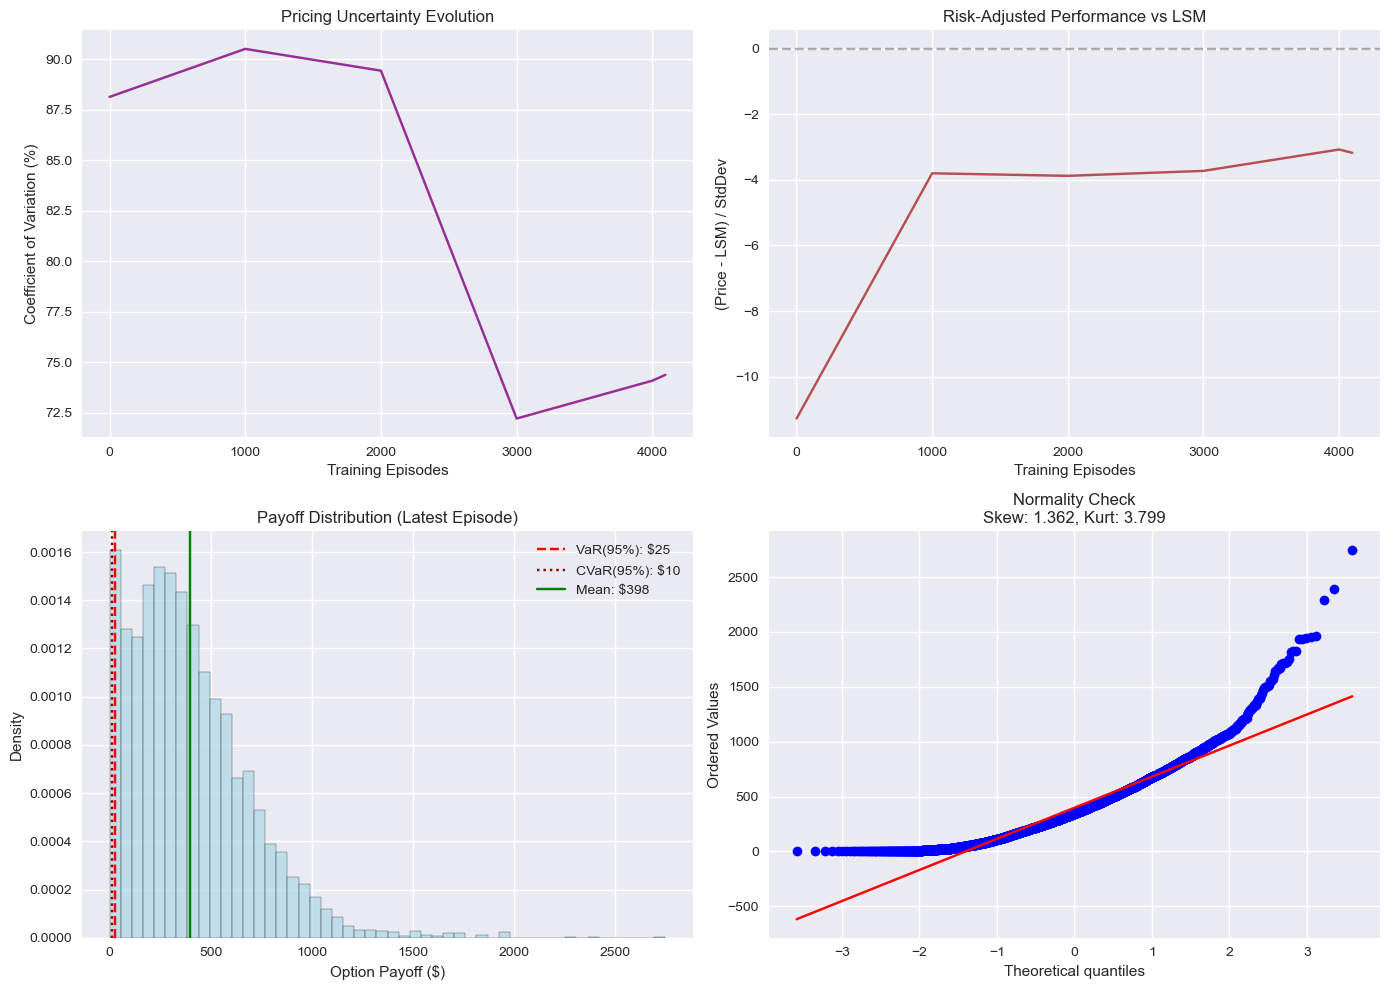

Risk Metrics (Latest Episode, N=4,096):
VaR(95%): $24.62 | CVaR(95%): $9.97
Skewness: 1.362 | Excess Kurtosis: 3.799
Price Volatility: 74.36% | Final CoV vs Initial: 0.84x


In [ ]:
# Risk-Return Evolution
price_volatility = eval_clean['price_std'] / eval_clean['option_price'] * 100
sharpe_proxy = (eval_clean['option_price'] - lsm_price) / eval_clean['price_std']

# Return Distribution Analysis (Latest Episode)
latest_returns = latest_episode['return']
var_95 = np.percentile(latest_returns, 5)
cvar_95 = latest_returns[latest_returns <= var_95].mean()
skewness = stats.skew(latest_returns)
kurtosis = stats.kurtosis(latest_returns)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Price Volatility Evolution
ax1.plot(eval_clean['training_episode'], price_volatility, 'purple', alpha=0.8)
ax1.set_xlabel('Training Episodes'); ax1.set_ylabel('Coefficient of Variation (%)')
ax1.set_title('Pricing Uncertainty Evolution'); ax1.grid(True)

# Sharpe-like Ratio (vs LSM)
ax2.plot(eval_clean['training_episode'], sharpe_proxy, 'brown', alpha=0.8)
ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('Training Episodes'); ax2.set_ylabel('(Price - LSM) / StdDev')
ax2.set_title('Risk-Adjusted Performance vs LSM'); ax2.grid(True)

# Return Distribution
ax3.hist(latest_returns, bins=50, alpha=0.7, density=True, color='lightblue', edgecolor='black')
ax3.axvline(var_95, color='red', linestyle='--', label=f'VaR(95%): ${var_95:.0f}')
ax3.axvline(cvar_95, color='darkred', linestyle=':', label=f'CVaR(95%): ${cvar_95:.0f}')
ax3.axvline(latest_returns.mean(), color='green', linestyle='-', label=f'Mean: ${latest_returns.mean():.0f}')
ax3.set_xlabel('Option Payoff ($)'); ax3.set_ylabel('Density')
ax3.set_title('Payoff Distribution (Latest Episode)'); ax3.legend(); ax3.grid(True)

# Q-Q Plot for Normality
stats.probplot(latest_returns, dist="norm", plot=ax4)
ax4.set_title(f'Normality Check\nSkew: {skewness:.3f}, Kurt: {kurtosis:.3f}')
ax4.grid(True)

plt.tight_layout(); plt.show()

print(f"Risk Metrics (Latest Episode, N={len(latest_returns):,}):")
print(f"VaR(95%): ${var_95:.2f} | CVaR(95%): ${cvar_95:.2f}")
print(f"Skewness: {skewness:.3f} | Excess Kurtosis: {kurtosis:.3f}")
print(f"Price Volatility: {price_volatility.iloc[-1]:.2f}% | Final CoV vs Initial: {price_volatility.iloc[-1]/price_volatility.iloc[0]:.2f}x")

## Learning Efficiency & Convergence Metrics

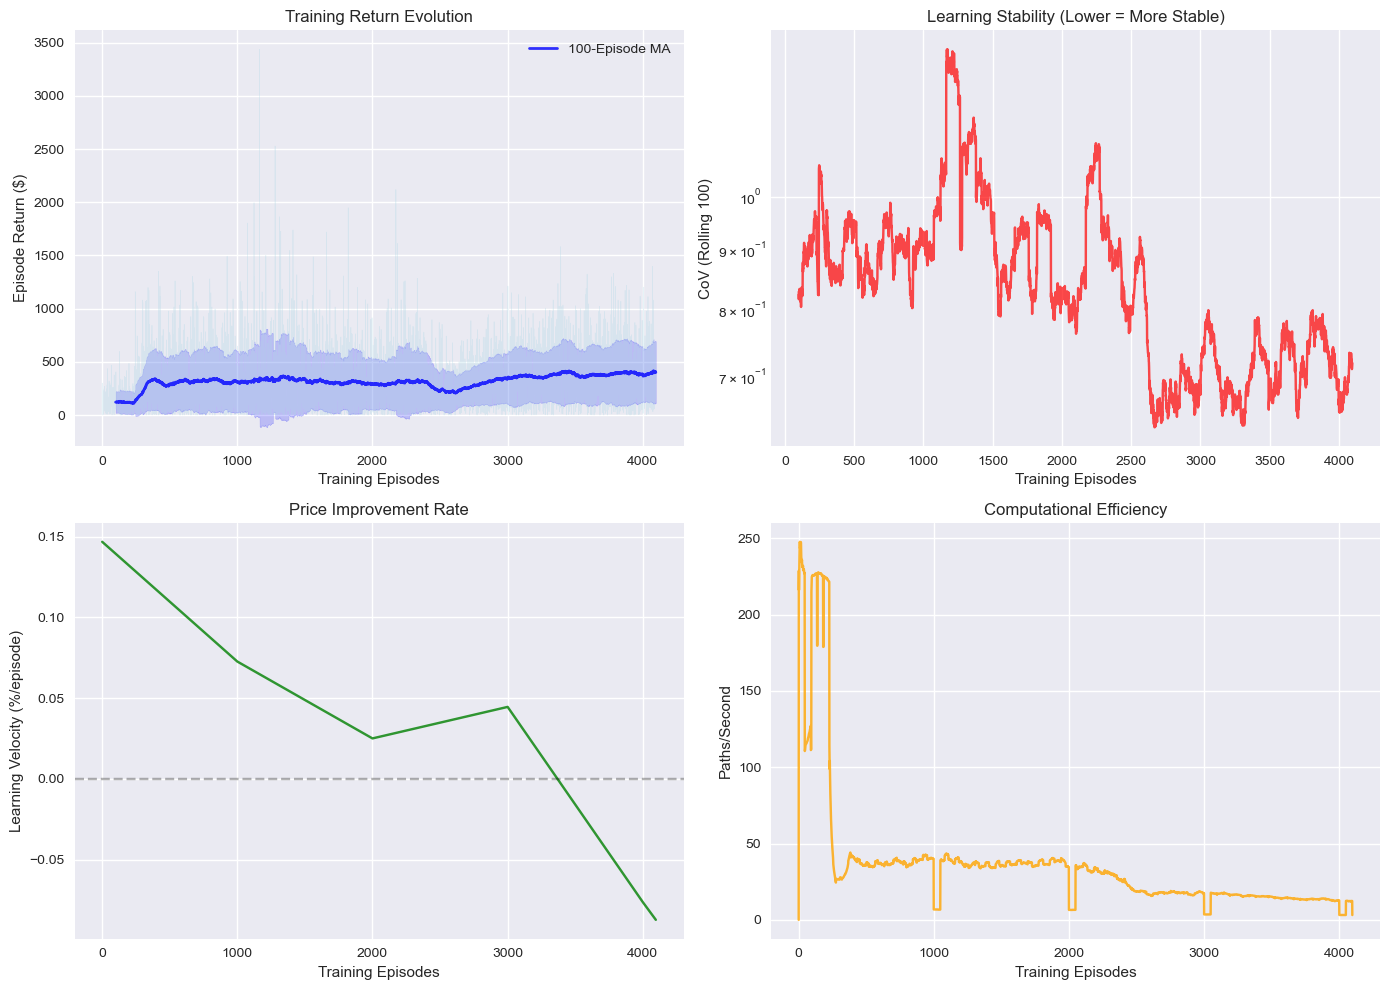

Learning Metrics:
Final Stability (CoV): 0.6868 | Peak Learning Rate: 0.1468%/episode
Avg Computational Efficiency: 36 paths/sec
Total Training Time: 226.4s | Final 100-ep Avg Return: $400.90


In [ ]:
# Training Performance Analysis
returns_ma = train_df['return'].rolling(100).mean()
returns_std = train_df['return'].rolling(100).std()
convergence_metric = returns_std / returns_ma.abs()

# Learning Rate Analysis
price_improvement = (eval_clean['option_price'] - eval_clean['option_price'].iloc[0]) / eval_clean['option_price'].iloc[0] * 100
learning_velocity = np.gradient(price_improvement, eval_clean['training_episode'])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Training Return Evolution
ax1.plot(train_df['episode'], train_df['return'], alpha=0.3, color='lightblue', linewidth=0.5)
ax1.plot(train_df['episode'], returns_ma, 'blue', alpha=0.8, linewidth=2, label='100-Episode MA')
ax1.fill_between(train_df['episode'], returns_ma - returns_std, returns_ma + returns_std, alpha=0.2, color='blue')
ax1.set_xlabel('Training Episodes'); ax1.set_ylabel('Episode Return ($)')
ax1.set_title('Training Return Evolution'); ax1.legend(); ax1.grid(True)

# Convergence Stability
ax2.plot(train_df['episode'], convergence_metric, 'red', alpha=0.7)
ax2.set_xlabel('Training Episodes'); ax2.set_ylabel('CoV (Rolling 100)')
ax2.set_title('Learning Stability (Lower = More Stable)'); ax2.grid(True)
ax2.set_yscale('log')

# Price Learning Velocity
ax3.plot(eval_clean['training_episode'], learning_velocity, 'green', alpha=0.8)
ax3.axhline(0, color='k', linestyle='--', alpha=0.3)
ax3.set_xlabel('Training Episodes'); ax3.set_ylabel('Learning Velocity (%/episode)')
ax3.set_title('Price Improvement Rate'); ax3.grid(True)

# Performance Efficiency
computational_efficiency = train_df['paths_per_sec']
ax4.plot(train_df['episode'], computational_efficiency, 'orange', alpha=0.8)
ax4.set_xlabel('Training Episodes'); ax4.set_ylabel('Paths/Second')
ax4.set_title('Computational Efficiency'); ax4.grid(True)

plt.tight_layout(); plt.show()

final_stability = convergence_metric.iloc[-100:].mean()
peak_learning = learning_velocity.max()
avg_efficiency = computational_efficiency.mean()

print(f"Learning Metrics:")
print(f"Final Stability (CoV): {final_stability:.4f} | Peak Learning Rate: {peak_learning:.4f}%/episode")
print(f"Avg Computational Efficiency: {avg_efficiency:,.0f} paths/sec")
print(f"Total Training Time: {train_df['time_elapsed'].iloc[-1]:.1f}s | Final 100-ep Avg Return: ${returns_ma.iloc[-1]:.2f}")

## Greeks Approximation & Sensitivity Analysis

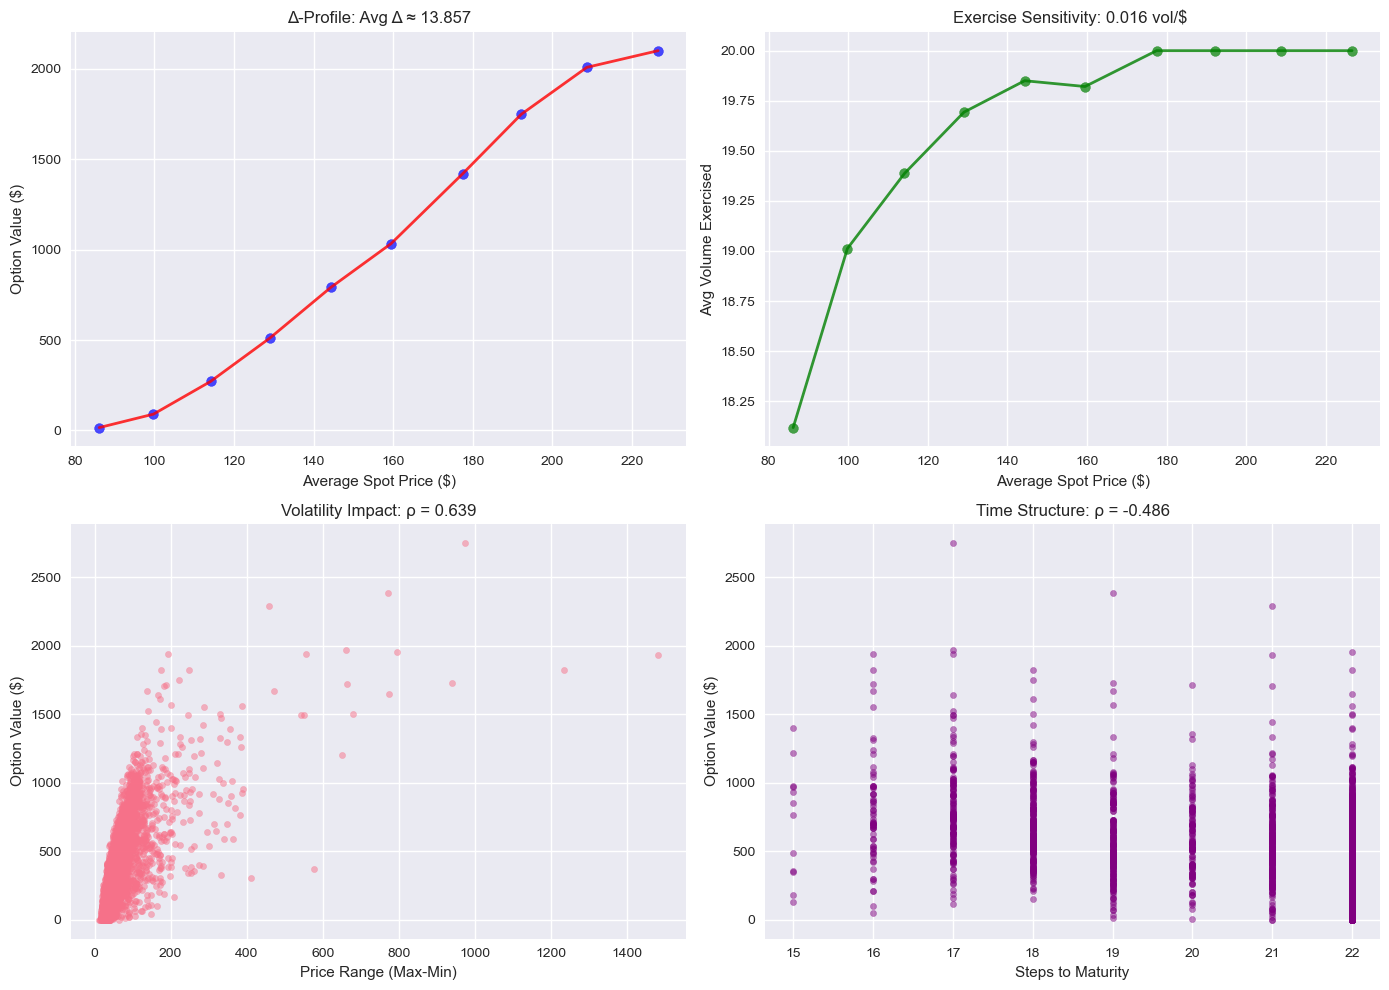

Greeks Approximation (Finite Differences):
Delta (∂V/∂S): 13.8571
Gamma (∂²V/∂S²): 0.004538
Volatility Correlation: 0.639 | Time Structure Correlation: -0.486
Exercise Sensitivity (∂Q/∂S): 0.0163 vol/$


In [ ]:
# Approximate Greeks via Finite Differences (using episode variations)
# Delta approximation: sensitivity to spot price variations within episodes
spot_price_range = latest_episode['avg_spot_price']
option_values = latest_episode['return']

# Binning for Delta estimation
n_bins = 10
spot_bins = pd.cut(spot_price_range, bins=n_bins)
binned_data = latest_episode.groupby(spot_bins).agg({
    'return': ['mean', 'std', 'count'],
    'avg_spot_price': 'mean',
    'total_exercised': 'mean'
}).round(3)

# Delta approximation
spot_centers = binned_data[('avg_spot_price', 'mean')].dropna()
option_means = binned_data[('return', 'mean')].dropna()
if len(spot_centers) > 1:
    delta_approx = np.gradient(option_means, spot_centers)
    avg_delta = np.mean(delta_approx)
else:
    avg_delta = np.nan

# Gamma approximation (second derivative)
if len(spot_centers) > 2:
    gamma_approx = np.gradient(delta_approx, spot_centers)
    avg_gamma = np.mean(gamma_approx)
else:
    avg_gamma = np.nan

# Vega proxy: relationship between price volatility and option value
price_volatility_episodes = latest_episode.groupby(pd.cut(latest_episode['max_spot_price'] - latest_episode['min_spot_price'], 5))['return'].mean()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Delta Profile
ax1.scatter(spot_centers, option_means, s=50, alpha=0.7, c='blue')
if len(spot_centers) > 1:
    ax1.plot(spot_centers, option_means, 'r-', alpha=0.8, linewidth=2)
ax1.set_xlabel('Average Spot Price ($)'); ax1.set_ylabel('Option Value ($)')
ax1.set_title(f'Δ-Profile: Avg Δ ≈ {avg_delta:.3f}' if not np.isnan(avg_delta) else 'Δ-Profile')
ax1.grid(True)

# Exercise Sensitivity
exercise_by_spot = binned_data[('total_exercised', 'mean')].dropna()
ax2.scatter(spot_centers, exercise_by_spot, s=50, alpha=0.7, c='green')
if len(spot_centers) > 1 and len(exercise_by_spot) > 1:
    exercise_sensitivity = np.gradient(exercise_by_spot, spot_centers)
    avg_exercise_sens = np.mean(exercise_sensitivity)
    ax2.plot(spot_centers, exercise_by_spot, 'g-', alpha=0.8, linewidth=2)
    title_text = f'Exercise Sensitivity: {avg_exercise_sens:.3f} vol/$ '
else:
    title_text = 'Exercise Sensitivity'
ax2.set_xlabel('Average Spot Price ($)'); ax2.set_ylabel('Avg Volume Exercised')
ax2.set_title(title_text); ax2.grid(True)

# Volatility Impact
vol_proxy = latest_episode['max_spot_price'] - latest_episode['min_spot_price']
ax3.scatter(vol_proxy, latest_episode['return'], alpha=0.5, s=20)
vol_corr = vol_proxy.corr(latest_episode['return'])
ax3.set_xlabel('Price Range (Max-Min)'); ax3.set_ylabel('Option Value ($)')
ax3.set_title(f'Volatility Impact: ρ = {vol_corr:.3f}'); ax3.grid(True)

# Time Decay Proxy (steps vs return)
ax4.scatter(latest_episode['steps'], latest_episode['return'], alpha=0.5, s=20, c='purple')
time_corr = latest_episode['steps'].corr(latest_episode['return'])
ax4.set_xlabel('Steps to Maturity'); ax4.set_ylabel('Option Value ($)')
ax4.set_title(f'Time Structure: ρ = {time_corr:.3f}'); ax4.grid(True)

plt.tight_layout(); plt.show()

print(f"Greeks Approximation (Finite Differences):")
if not np.isnan(avg_delta): print(f"Delta (∂V/∂S): {avg_delta:.4f}")
if not np.isnan(avg_gamma): print(f"Gamma (∂²V/∂S²): {avg_gamma:.6f}")
print(f"Volatility Correlation: {vol_corr:.3f} | Time Structure Correlation: {time_corr:.3f}")
if 'avg_exercise_sens' in locals(): print(f"Exercise Sensitivity (∂Q/∂S): {avg_exercise_sens:.4f} vol/$")

## Final Performance Summary

In [ ]:
# Comprehensive Performance Summary
final_price = d4pg_prices.iloc[-1]
price_error_pct = (final_price - lsm_price) / lsm_price * 100
price_error_stds = (final_price - lsm_price) / lsm_std

# Risk-adjusted metrics
final_cv = eval_clean['price_std'].iloc[-1] / final_price * 100
pricing_efficiency = (final_price / lsm_price - 1) * 100 if abs(price_error_pct) < 10 else -abs(price_error_pct)

# Exercise efficiency
volume_efficiency = eval_clean['avg_total_exercised'].iloc[-1] / Q_max * 100
rights_utilization = eval_clean['avg_exercise_count'].iloc[-1] / n_rights * 100

# Statistical significance
is_significant = abs(price_error_stds) > 1.96
confidence_level = (1 - 2 * stats.norm.sf(abs(price_error_stds))) * 100 if is_significant else 0

print("="*60)
print(f"SWING OPTION PRICING ANALYSIS - {EXPERIMENT}")
print("="*60)
print(f"CONTRACT SPECIFICATION:")
print(f"  Underlying: HHK Process (α={alpha}, σ={sigma}, β={beta}, λ={lam})")
print(f"  Contract: {n_rights} rights over {T:.1f}Y, Strike=${K}, S₀=${S0}")
print(f"  Constraints: q∈[{q_min}, {q_max}], Q≤{Q_max}")
print()
print(f"PRICING PERFORMANCE:")
print(f"  LSM Benchmark:    ${lsm_price:8.2f} ± ${lsm_std:.2f}")
print(f"  D4PG Final:       ${final_price:8.2f}")
print(f"  Absolute Error:   ${abs(final_price - lsm_price):8.2f}")
print(f"  Relative Error:   {price_error_pct:8.2f}%")
print(f"  Statistical Sig:  {price_error_stds:8.2f}σ {'***' if is_significant else ''}")
if is_significant: print(f"  Confidence:       {confidence_level:8.1f}%")
print()
print(f"EXERCISE STRATEGY:")
print(f"  Volume Utilization: {volume_efficiency:6.1f}%")
print(f"  Rights Usage:       {rights_utilization:6.1f}%")
print(f"  Price-Volume ρ:     {corr_price_volume:6.3f}")
print()
print(f"RISK METRICS:")
print(f"  Coefficient of Variation: {final_cv:6.2f}%")
print(f"  VaR(95%):               ${var_95:8.0f}")
print(f"  CVaR(95%):              ${cvar_95:8.0f}")
print(f"  Skewness:                {skewness:6.3f}")
print(f"  Excess Kurtosis:         {kurtosis:6.3f}")
print()
print(f"LEARNING EFFICIENCY:")
print(f"  Training Episodes:    {len(train_df):8,}")
print(f"  Convergence Stability: {final_stability:6.4f}")
print(f"  Computational Rate:   {avg_efficiency:8,.0f} paths/sec")
if not np.isnan(avg_delta): print(f"  Approximate Delta:     {avg_delta:6.4f}")
print("="*60)

# Performance Grade
grade = 'A' if abs(price_error_pct) < 2 else 'B' if abs(price_error_pct) < 5 else 'C' if abs(price_error_pct) < 10 else 'D'
print(f"OVERALL PERFORMANCE GRADE: {grade}")
print("="*60)

SWING OPTION PRICING ANALYSIS - MonthlySwing_d1
CONTRACT SPECIFICATION:
  Underlying: HHK Process (α=12.0, σ=1.2, β=150.0, λ=6.0)
  Contract: 22 rights over 0.1Y, Strike=$100.0, S₀=$100.0
  Constraints: q∈[0.0, 2.0], Q≤20.0

PRICING PERFORMANCE:
  LSM Benchmark:    $ 1337.50 ± $1.65
  D4PG Final:       $  398.24
  Absolute Error:   $  939.26
  Relative Error:     -70.23%
  Statistical Sig:   -568.54σ ***
  Confidence:          100.0%

EXERCISE STRATEGY:
  Volume Utilization:   97.3%
  Rights Usage:         63.6%
  Price-Volume ρ:      0.400

RISK METRICS:
  Coefficient of Variation:  74.36%
  VaR(95%):               $      25
  CVaR(95%):              $      10
  Skewness:                 1.362
  Excess Kurtosis:          3.799

LEARNING EFFICIENCY:
  Training Episodes:       4,096
  Convergence Stability: 0.6868
  Computational Rate:         36 paths/sec
  Approximate Delta:     13.8571
OVERALL PERFORMANCE GRADE: D
